In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import timm
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import os
os.environ["DISABLE_IPYWIDGETS"] = "1"


In [2]:
CONFIG = {
    "feature_dir": Path("features"),
    "batch_size": 8,
    "epochs": 25,
    "lr": 3e-5,
    "d_model": 256,
    "nhead": 8,
    "num_layers": 2,
    "sfm_dim": 7,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print("Running on:", CONFIG["device"])


Running on: cuda


In [3]:
class MelSFMDataset(Dataset):
    def __init__(self, split="train"):
        self.mel_dir = CONFIG["feature_dir"] / "mel" / split
        self.sfm_dir = CONFIG["feature_dir"] / "sfm" / split

        self.classes = sorted([d.name for d in self.mel_dir.iterdir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.files = []
        for cls in self.classes:
            for f in (self.mel_dir / cls).glob("*.npy"):
                sfm_path = self.sfm_dir / cls / f.name
                if sfm_path.exists():
                    self.files.append((f, sfm_path, self.class_to_idx[cls]))

        print(f"{split}: {len(self.files)} samples")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel_path, sfm_path, label = self.files[idx]

        mel = torch.from_numpy(np.load(mel_path)).float()   # (T, 80)
        sfm = torch.from_numpy(np.load(sfm_path)).float()   # (T, 7)

        return mel, sfm, torch.tensor(label)


In [4]:
def collate_fn(batch):
    mel, sfm, labels = zip(*batch)

    mel_pad = pad_sequence(mel, batch_first=True)
    sfm_pad = pad_sequence(sfm, batch_first=True)

    mel_lengths = torch.tensor([x.size(0) for x in mel])
    sfm_lengths = torch.tensor([x.size(0) for x in sfm])

    mel_mask = torch.arange(mel_pad.size(1))[None, :] < mel_lengths[:, None]
    sfm_mask = torch.arange(sfm_pad.size(1))[None, :] < sfm_lengths[:, None]

    return mel_pad, sfm_pad, mel_mask, sfm_mask, torch.stack(labels)


In [5]:
import torch
import torch.nn as nn
import timm
import torch.nn.functional as Fnn

class MelSFM_EVA02(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # ---- EVA-02 BACKBONE ----
        self.eva = timm.create_model(
            "eva02_tiny_patch14_224.mim_in22k",
            pretrained=True,
            num_classes=0
        )
        eva_dim = self.eva.num_features

        # ---- PROJECTIONS & NORMALIZATION (The Fix!) ----
        self.mel_proj = nn.Linear(eva_dim, CONFIG["d_model"])
        self.sfm_proj = nn.Linear(CONFIG["sfm_dim"], CONFIG["d_model"])
        
        # FIX 1: Normalize inputs immediately to handle large Pitch/Energy values
        self.mel_norm_input = nn.LayerNorm(CONFIG["d_model"])
        self.sfm_norm_input = nn.LayerNorm(CONFIG["d_model"])

        # ---- SFM TRANSFORMER ----
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=CONFIG["d_model"],
            nhead=CONFIG["nhead"],
            batch_first=True,
            dropout=0.1
        )
        self.sfm_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=CONFIG["num_layers"]
        )

        # ---- CROSS ATTENTION ----
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=CONFIG["d_model"],
            num_heads=CONFIG["nhead"],
            batch_first=True,
            dropout=0.1
        )

        self.norm = nn.LayerNorm(CONFIG["d_model"])

        # ---- CLASSIFIER ----
        self.classifier = nn.Sequential(
            nn.Linear(CONFIG["d_model"], 128),
            nn.LayerNorm(128), # Added extra stability
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, mel, sfm, sfm_mask):
        """
        mel: (B, Tm, 80)
        sfm: (B, Ts, 7)
        sfm_mask: (B, Ts)
        """

        # ---- MEL → IMAGE ----
        mel_img = mel.unsqueeze(1)  # (B,1,Tm,80)
        mel_img = Fnn.interpolate(
            mel_img,
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        )
        mel_img = mel_img.repeat(1, 3, 1, 1)  # (B,3,224,224)

        # ---- EVA ----
        mel_feat = self.eva(mel_img)          # (B, eva_dim)
        mel_feat = self.mel_proj(mel_feat)    # (B, d_model)
        
        # Normalize the projected features
        mel_feat = self.mel_norm_input(mel_feat)
        mel_feat = mel_feat.unsqueeze(1)      # (B,1,d_model)

        # ---- SFM ----
        sfm_emb = self.sfm_proj(sfm)          # (B, Ts, d_model)
        sfm_emb = self.sfm_norm_input(sfm_emb) # Normalize Pitch/Energy here!
        
        sfm_feat = self.sfm_encoder(
            sfm_emb,
            src_key_padding_mask=~sfm_mask
        )

        # ---- CROSS ATTENTION ----
        # Query = Mel (What implies pathology?)
        # Key/Value = SFM (Is it supported by jitter/shimmer?)
        fused, attn = self.cross_attn(
            query=mel_feat,
            key=sfm_feat,
            value=sfm_feat,
            key_padding_mask=~sfm_mask
        )

        fused = self.norm(fused.squeeze(1))   # (B,d_model)
        logits = self.classifier(fused)

        return logits, attn

In [6]:
import sys

def ascii_progress(current, total, bar_len=30, prefix=""):
    filled_len = int(bar_len * current / total)
    bar = "=" * filled_len + "-" * (bar_len - filled_len)
    percent = 100 * current / total
    sys.stdout.write(f"\r{prefix} [{bar}] {percent:5.1f}%")
    sys.stdout.flush()

def train():
    # Re-initialize dataset/loaders to be safe
    train_ds = MelSFMDataset("train")
    val_ds   = MelSFMDataset("val")
    CLASSES = train_ds.classes

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collate_fn)

    # Class Weights
    labels = [x[2] for x in train_ds.files]
    weights = compute_class_weight(class_weight="balanced", classes=np.arange(len(CLASSES)), y=labels)
    weights = torch.tensor(weights).float().to(CONFIG["device"])

    # Initialize New Model
    model = MelSFM_EVA02(len(CLASSES)).to(CONFIG["device"])
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    # Slightly lower LR for stability
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

    best_acc = 0.0

    print("\n🚀 Training Restarted with Gradient Clipping & Normalization")
    print("=" * 60)

    for epoch in range(CONFIG["epochs"]):
        # ================= TRAIN =================
        model.train()
        train_loss = 0.0
        total_batches = len(train_loader)

        print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")

        for i, (mel, sfm, mel_mask, sfm_mask, y) in enumerate(train_loader, start=1):
            mel, sfm, sfm_mask, y = mel.to(CONFIG["device"]), sfm.to(CONFIG["device"]), sfm_mask.to(CONFIG["device"]), y.to(CONFIG["device"])

            optimizer.zero_grad()
            out, _ = model(mel, sfm, sfm_mask)
            loss = criterion(out, y)
            
            # Check for NaN before backward
            if torch.isnan(loss):
                print(f"⚠️ NaN detected at batch {i}! Skipping...")
                continue

            loss.backward()
            
            # FIX 2: Gradient Clipping (Crucial for Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()

            ascii_progress(i, total_batches, bar_len=35, prefix="Train")

        train_loss /= total_batches
        print(f" | Loss: {train_loss:.4f}")

        # ================= VALIDATION =================
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for mel, sfm, mel_mask, sfm_mask, y in val_loader:
                mel, sfm, sfm_mask, y = mel.to(CONFIG["device"]), sfm.to(CONFIG["device"]), sfm_mask.to(CONFIG["device"]), y.to(CONFIG["device"])
                preds = model(mel, sfm, sfm_mask)[0].argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_mel_sfm_eva02.pth")
            print("💾 Best model saved")

    print("\n" + "=" * 60)
    print(f"✅ Training finished | Best Val Acc: {best_acc:.2f}%")
    return model, CLASSES

# Run it
model, CLASSES = train()

train: 14740 samples
val: 920 samples

🚀 Training Restarted with Gradient Clipping & Normalization

Epoch 1/25
Train [===================================] 100.0% | Loss: 1.5056


c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Validation Accuracy: 79.13%
💾 Best model saved

Epoch 2/25
Train [===================================] 100.0% | Loss: 1.3068
Validation Accuracy: 82.07%
💾 Best model saved

Epoch 3/25
Train [===================================] 100.0% | Loss: 1.2161
Validation Accuracy: 83.80%
💾 Best model saved

Epoch 4/25
Train [===================================] 100.0% | Loss: 1.1860
Validation Accuracy: 85.54%
💾 Best model saved

Epoch 5/25
Train [===================================] 100.0% | Loss: 1.1369
Validation Accuracy: 85.65%
💾 Best model saved

Epoch 6/25
Train [===================================] 100.0% | Loss: 1.1347
Validation Accuracy: 86.41%
💾 Best model saved

Epoch 7/25
Train [===================================] 100.0% | Loss: 1.1046
Validation Accuracy: 86.30%

Epoch 8/25
Train [===================================] 100.0% | Loss: 1.0604
Validation Accuracy: 85.98%

Epoch 9/25
Train [===================================] 100.0% | Loss: 0.8771
Validation Accuracy: 67.72%

Epoch 10/

KeyboardInterrupt: 

test: 350 samples
📂 Found 350 samples in the Test set.
✅ Successfully loaded best model weights from: best_mel_sfm_eva02.pth
🚀 Running Inference on Test Data...

📊 CLASSIFICATION REPORT
                        precision    recall  f1-score   support

      Cysts_Structural       0.78      0.32      0.45        22
             Dysarthia       0.97      0.86      0.91        42
       Hyperfunctional       0.30      0.35      0.32        31
            Laryngitis       0.22      0.10      0.13        42
           Vox senilis       0.65      0.67      0.66        93
             parkinson       0.66      0.98      0.79       100
spasmodische_dysphonie       0.60      0.15      0.24        20

              accuracy                           0.63       350
             macro avg       0.60      0.49      0.50       350
          weighted avg       0.61      0.63      0.60       350



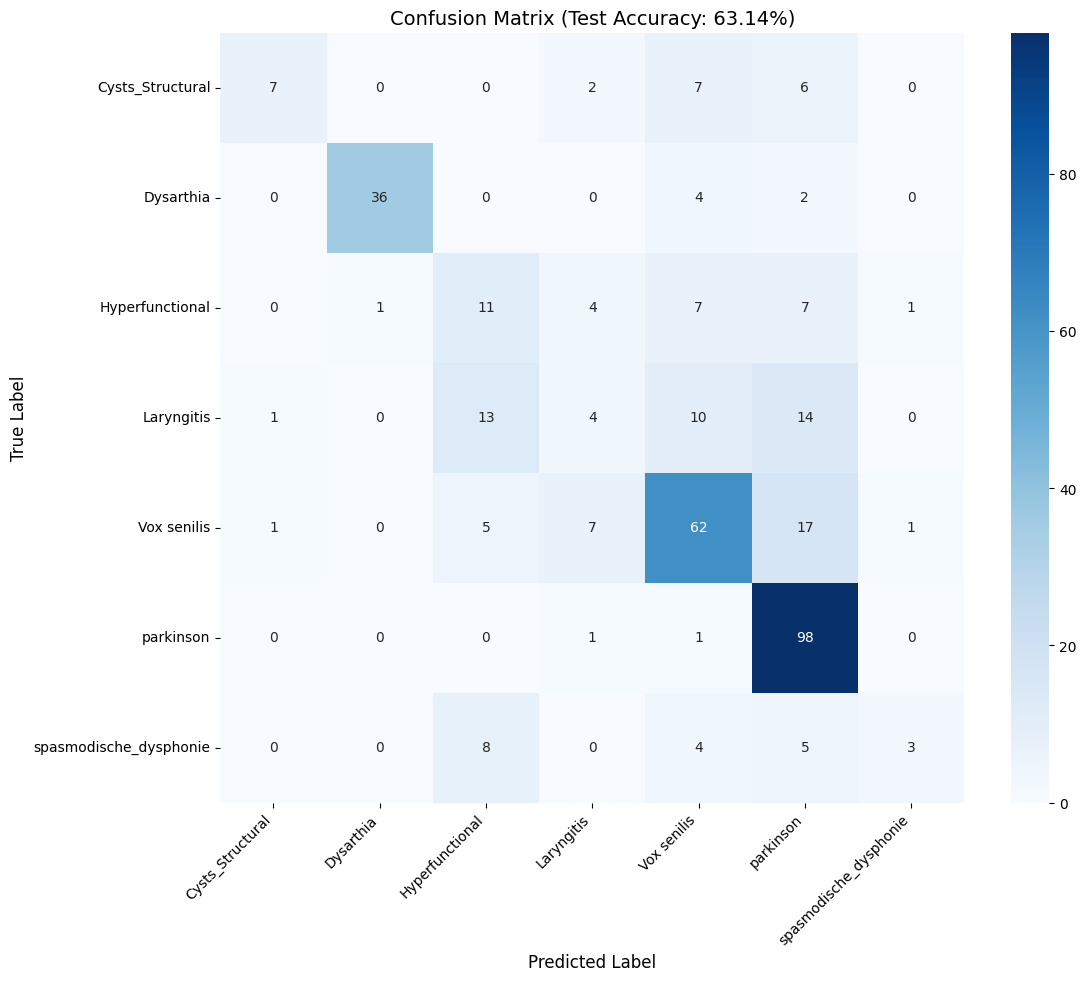

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def run_test_evaluation():
    # 1. Setup Test Loader
    test_ds = MelSFMDataset("test")
    # Using the same collate_fn and batch size as training
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collate_fn)
    
    print(f"📂 Found {len(test_ds)} samples in the Test set.")

    # 2. Re-initialize Model Architecture
    model = MelSFM_EVA02(num_classes=len(test_ds.classes)).to(CONFIG["device"])
    
    # 3. Load the BEST Saved Weights (Crucial Step)
    weights_path = "best_mel_sfm_eva02.pth"
    if not os.path.exists(weights_path):
        print(f"❌ Error: '{weights_path}' not found. Make sure you are in the same directory where you trained.")
        return

    state_dict = torch.load(weights_path, map_location=CONFIG["device"])
    model.load_state_dict(state_dict)
    model.eval()
    print(f"✅ Successfully loaded best model weights from: {weights_path}")

    # 4. Run Inference
    all_preds = []
    all_labels = []
    
    print("🚀 Running Inference on Test Data...")
    with torch.no_grad():
        for mel, sfm, mel_mask, sfm_mask, y in test_loader:
            # Move to device
            mel = mel.to(CONFIG["device"])
            sfm = sfm.to(CONFIG["device"])
            sfm_mask = sfm_mask.to(CONFIG["device"])
            
            # Forward pass
            logits, _ = model(mel, sfm, sfm_mask)
            
            # Get predictions
            preds = logits.argmax(dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    # 5. Generate Metrics
    print("\n" + "="*60)
    print("📊 CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=test_ds.classes))
    
    # 6. Plot Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_ds.classes, yticklabels=test_ds.classes)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix (Test Accuracy: {100*sum(p==t for p,t in zip(all_preds, all_labels))/len(all_labels):.2f}%)", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Run the evaluation
run_test_evaluation()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler

# ================= 1. FOCAL LOSS (Better than CrossEntropy) =================
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

# ================= 2. BALANCED TRAINING LOOP =================
def train_balanced():
    # 1. Setup Datasets
    train_ds = MelSFMDataset("train")
    val_ds   = MelSFMDataset("val")
    CLASSES = train_ds.classes
    
    # 2. CREATE WEIGHTED SAMPLER (Crucial Step)
    # Get all labels from training set
    targets = [y for _, _, y in train_ds.files]
    class_counts = torch.bincount(torch.tensor(targets))
    
    # Calculate weight per class (inverse of frequency)
    class_weights = 1. / class_counts.float()
    
    # Assign a weight to EVERY sample in the dataset
    sample_weights = [class_weights[y] for y in targets]
    
    # Create the sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True 
    )
    
    # 3. Loaders (Notice: shuffle=False when using sampler)
    train_loader = DataLoader(
        train_ds, 
        batch_size=CONFIG["batch_size"], 
        sampler=sampler,               # <--- This forces balance
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_ds, 
        batch_size=CONFIG["batch_size"], 
        shuffle=False, 
        collate_fn=collate_fn
    )

    # 4. Model & Optimization
    model = MelSFM_EVA02(len(CLASSES)).to(CONFIG["device"])
    
    # Switch to Focal Loss
    criterion = FocalLoss(gamma=2.0).to(CONFIG["device"])
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

    best_acc = 0.0
    print("\n🚀 Starting BALANCED Training (Weighted Sampler + Focal Loss)")
    print("=" * 60)

    for epoch in range(CONFIG["epochs"]):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0
        
        for i, (mel, sfm, mel_mask, sfm_mask, y) in enumerate(train_loader):
            mel, sfm, sfm_mask, y = mel.to(CONFIG["device"]), sfm.to(CONFIG["device"]), sfm_mask.to(CONFIG["device"]), y.to(CONFIG["device"])

            optimizer.zero_grad()
            out, _ = model(mel, sfm, sfm_mask)
            loss = criterion(out, y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATE ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for mel, sfm, mel_mask, sfm_mask, y in val_loader:
                mel, sfm, sfm_mask, y = mel.to(CONFIG["device"]), sfm.to(CONFIG["device"]), sfm_mask.to(CONFIG["device"]), y.to(CONFIG["device"])
                preds = model(mel, sfm, sfm_mask)[0].argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = 100 * correct / total
        
        # Update Scheduler
        scheduler.step(val_acc)
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_mel_sfm_balanced.pth")
            print("💾 Best model saved")

    print(f"\n✅ Finished. Best Val Acc: {best_acc:.2f}%")
    return model, CLASSES

# Run balanced training
model, CLASSES = train_balanced()

train: 14740 samples
val: 920 samples

🚀 Starting BALANCED Training (Weighted Sampler + Focal Loss)
Epoch 1/25 | Loss: 0.9234 | Val Acc: 56.52%
💾 Best model saved
Epoch 2/25 | Loss: 0.7150 | Val Acc: 81.63%
💾 Best model saved
Epoch 3/25 | Loss: 0.6130 | Val Acc: 58.48%
Epoch 4/25 | Loss: 0.5536 | Val Acc: 61.09%
Epoch 5/25 | Loss: 0.5143 | Val Acc: 80.43%
Epoch 6/25 | Loss: 0.4643 | Val Acc: 64.24%
Epoch 7/25 | Loss: 0.4411 | Val Acc: 71.52%
Epoch 8/25 | Loss: 0.4184 | Val Acc: 86.09%
💾 Best model saved
Epoch 9/25 | Loss: 0.4091 | Val Acc: 87.50%
💾 Best model saved
Epoch 10/25 | Loss: 0.3998 | Val Acc: 85.98%
Epoch 11/25 | Loss: 0.3863 | Val Acc: 87.28%
Epoch 12/25 | Loss: 0.3508 | Val Acc: 86.41%
Epoch 13/25 | Loss: 0.1871 | Val Acc: 87.83%
💾 Best model saved
Epoch 14/25 | Loss: 0.1537 | Val Acc: 87.39%
Epoch 15/25 | Loss: 0.1374 | Val Acc: 88.48%
💾 Best model saved
Epoch 16/25 | Loss: 0.1378 | Val Acc: 87.72%
Epoch 17/25 | Loss: 0.1160 | Val Acc: 73.70%
Epoch 18/25 | Loss: 0.1128 | V

test: 350 samples
📂 Found 350 samples in the Balanced Test Set.
✅ Loaded model: best_mel_sfm_balanced.pth
🚀 Running Inference...

📊 BALANCED TEST RESULTS (No TTA)
                        precision    recall  f1-score   support

      Cysts_Structural       0.68      0.59      0.63        22
             Dysarthia       0.91      0.95      0.93        42
       Hyperfunctional       0.28      0.42      0.34        31
            Laryngitis       0.43      0.31      0.36        42
           Vox senilis       0.88      0.65      0.75        93
             parkinson       0.77      0.99      0.86       100
spasmodische_dysphonie       0.57      0.40      0.47        20

              accuracy                           0.70       350
             macro avg       0.65      0.62      0.62       350
          weighted avg       0.72      0.70      0.70       350



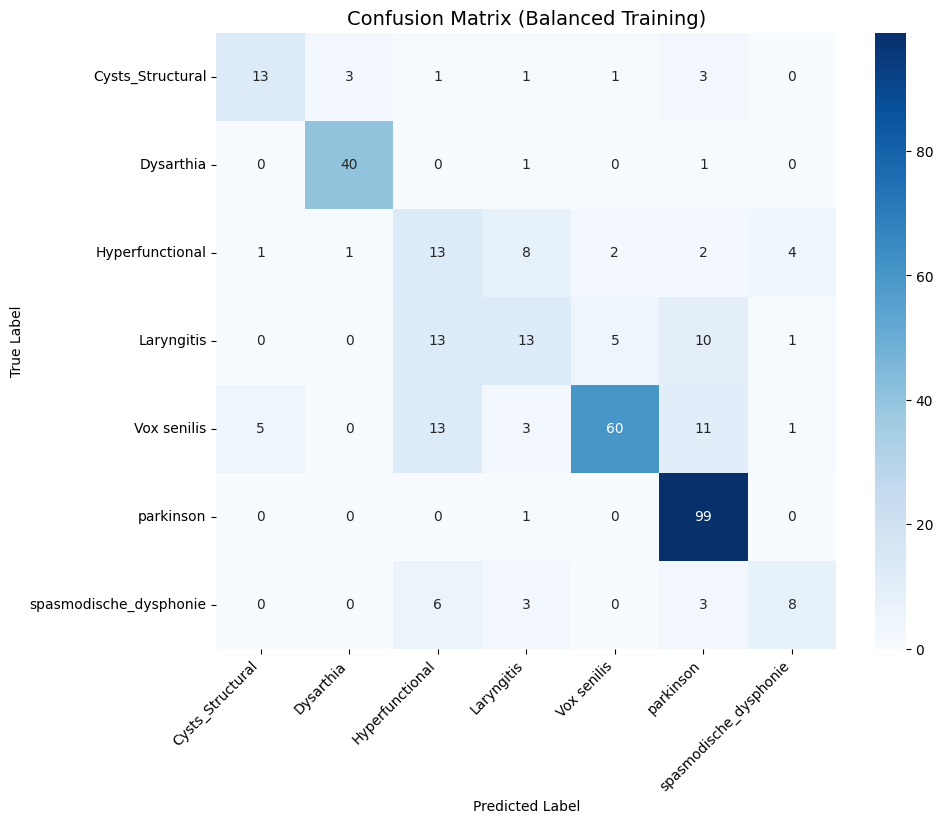

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

def run_standard_test():
    # 1. Load Test Data (Already downsampled to 100 Parkinson's)
    test_ds = MelSFMDataset("test")
    test_loader = DataLoader(
        test_ds, 
        batch_size=CONFIG["batch_size"], 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    print(f"📂 Found {len(test_ds)} samples in the Balanced Test Set.")

    # 2. Load the Retrained Balanced Model
    model = MelSFM_EVA02(len(test_ds.classes)).to(CONFIG["device"])
    weights_path = "best_mel_sfm_balanced.pth"
    
    if not os.path.exists(weights_path):
        print(f"❌ Error: '{weights_path}' not found. Did the balanced training finish?")
        return

    model.load_state_dict(torch.load(weights_path, map_location=CONFIG["device"]))
    model.eval()
    print(f"✅ Loaded model: {weights_path}")

    # 3. Inference Loop
    all_preds = []
    all_labels = []
    
    print("🚀 Running Inference...")
    with torch.no_grad():
        for mel, sfm, mel_mask, sfm_mask, y in test_loader:
            # Move to device
            mel = mel.to(CONFIG["device"])
            sfm = sfm.to(CONFIG["device"])
            sfm_mask = sfm_mask.to(CONFIG["device"])
            
            # Forward pass
            logits, _ = model(mel, sfm, sfm_mask)
            
            # Get predictions
            preds = logits.argmax(dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    # 4. Results
    print("\n" + "="*60)
    print("📊 BALANCED TEST RESULTS (No TTA)")
    print("="*60)
    
    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=test_ds.classes))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_ds.classes, yticklabels=test_ds.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (Balanced Training)", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Run it
run_standard_test()

📊 Processing 'train' set features (Please wait)...
   Done. Processed 14740 files. (Errors: 0)
📊 Processing 'val' set features (Please wait)...
   Done. Processed 920 files. (Errors: 0)
📊 Processing 'test' set features (Please wait)...
   Done. Processed 350 files. (Errors: 0)

✅ Data Loaded:
   Train: (14740, 348)
   Test:  (350, 348)

🚀 Training Gradient Boosting Ensemble...

📊 BOOSTING ENSEMBLE RESULTS
                        precision    recall  f1-score   support

      Cysts_Structural       0.94      0.73      0.82        22
             Dysarthia       0.97      0.93      0.95        42
       Hyperfunctional       0.19      0.13      0.15        31
            Laryngitis       0.55      0.62      0.58        42
           Vox senilis       0.79      0.86      0.82        93
             parkinson       0.89      0.98      0.93       100
spasmodische_dysphonie       0.64      0.45      0.53        20

              accuracy                           0.78       350
             

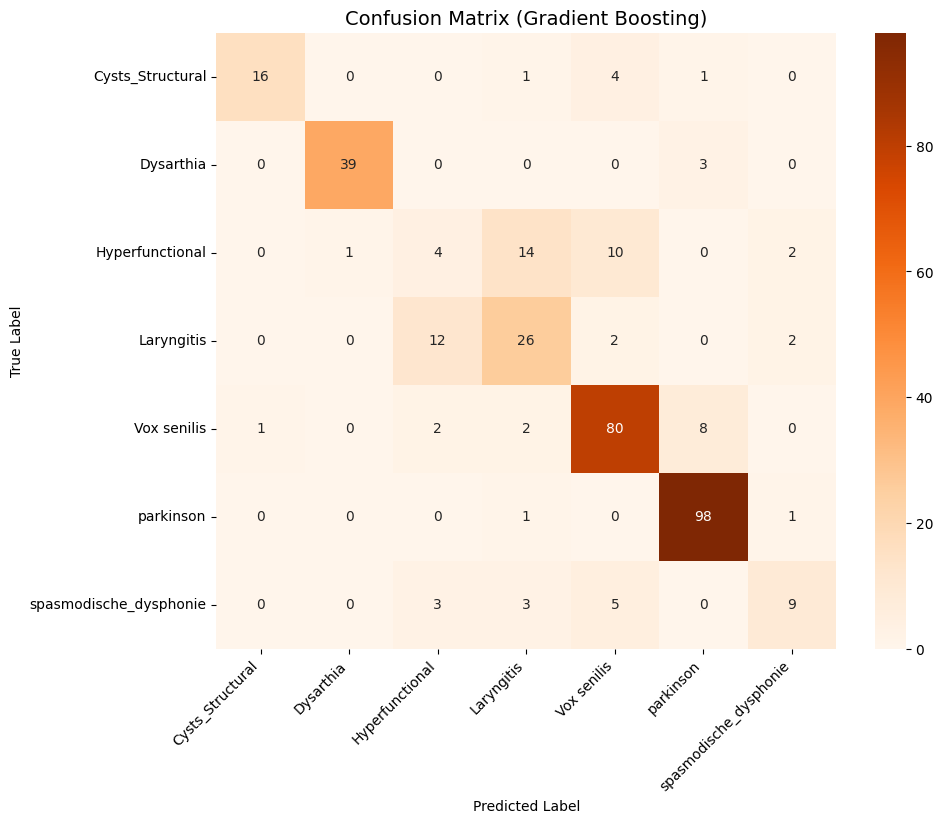

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
from pathlib import Path
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ================= CONFIG =================
FEATURE_DIR = Path("features")
# ==========================================

def load_tabular_features(split="train"):
    """
    Aggregates time-series .npy files into a single vector per patient.
    Autofixes shape mismatches between Mel and SFM.
    """
    mel_dir = FEATURE_DIR / "mel" / split
    sfm_dir = FEATURE_DIR / "sfm" / split
    
    # Auto-detect classes
    if not mel_dir.exists():
        print(f"❌ Error: {mel_dir} does not exist.")
        return np.array([]), np.array([]), []

    classes = sorted([d.name for d in mel_dir.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}
    
    X = []
    y = []
    
    print(f"📊 Processing '{split}' set features (Please wait)...")
    
    total_files = 0
    errors = 0
    
    for cls in classes:
        cls_mel_dir = mel_dir / cls
        cls_sfm_dir = sfm_dir / cls
        
        files = list(cls_mel_dir.glob("*.npy"))
        
        for f in files:
            sfm_path = cls_sfm_dir / f.name
            
            if not sfm_path.exists():
                continue 
                
            try:
                # 1. Load Data
                mel = np.load(f)      # (T_mel, 80)
                sfm = np.load(sfm_path) # (T_sfm, 7)
                
                # 2. Fix Dimension Mismatch (Resample SFM to match Mel)
                if mel.shape[0] != sfm.shape[0]:
                    # Resample SFM along time axis (axis 0) to match Mel's length
                    sfm = scipy.signal.resample(sfm, mel.shape[0], axis=0)
                
                # 3. Concatenate Features (T, 87)
                combined = np.hstack([mel, sfm])
                
                # 4. Collapse Time (Calculate Statistics)
                # Output shape: (87 * 4) = 348 features per patient
                stats = np.hstack([
                    np.mean(combined, axis=0),
                    np.std(combined, axis=0),
                    np.max(combined, axis=0),
                    np.min(combined, axis=0)
                ])
                
                X.append(stats)
                y.append(class_to_idx[cls])
                total_files += 1
            
            except Exception as e:
                errors += 1
                # print(f"⚠️ Error processing {f.name}: {e}")
            
    print(f"   Done. Processed {total_files} files. (Errors: {errors})")
    return np.array(X), np.array(y), classes

def run_boosting_experiment():
    # 1. Load Data
    X_train, y_train, classes = load_tabular_features("train")
    X_val, y_val, _ = load_tabular_features("val")
    # Note: This loads the BALANCED test set (100 Parkinson's)
    X_test, y_test, _ = load_tabular_features("test") 
    
    if len(X_train) == 0:
        print("❌ No data loaded. Check your folder paths.")
        return

    print(f"\n✅ Data Loaded:")
    print(f"   Train: {X_train.shape}")
    print(f"   Test:  {X_test.shape}")

    # 2. Scale Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # 3. Train Model
    print("\n🚀 Training Gradient Boosting Ensemble...")
    
    clf = HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_iter=300,
        max_depth=15,
        random_state=42,
        class_weight='balanced', 
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    
    clf.fit(X_train, y_train)
    
    # 4. Evaluate
    print("\n" + "="*60)
    print("📊 BOOSTING ENSEMBLE RESULTS")
    print("="*60)
    
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=classes))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Gradient Boosting)", fontsize=14)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Run it
run_boosting_experiment()


🚀 Step 1: Retraining Boosting Model...
📊 Loading 'train' stats...
✅ Boosting Model Ready.

🚀 Step 2: Loading Transformer...
✅ Transformer Loaded.

🚀 Step 3: Running Fusion on Balanced Test Set...

📊 HYBRID ENSEMBLE RESULTS
                        precision    recall  f1-score   support

      Cysts_Structural       0.94      0.73      0.82        22
             Dysarthia       0.97      0.93      0.95        42
       Hyperfunctional       0.20      0.13      0.16        31
            Laryngitis       0.56      0.60      0.57        42
           Vox senilis       0.80      0.87      0.84        93
             parkinson       0.88      1.00      0.93       100
spasmodische_dysphonie       0.77      0.50      0.61        20

              accuracy                           0.79       350
             macro avg       0.73      0.68      0.70       350
          weighted avg       0.77      0.79      0.77       350



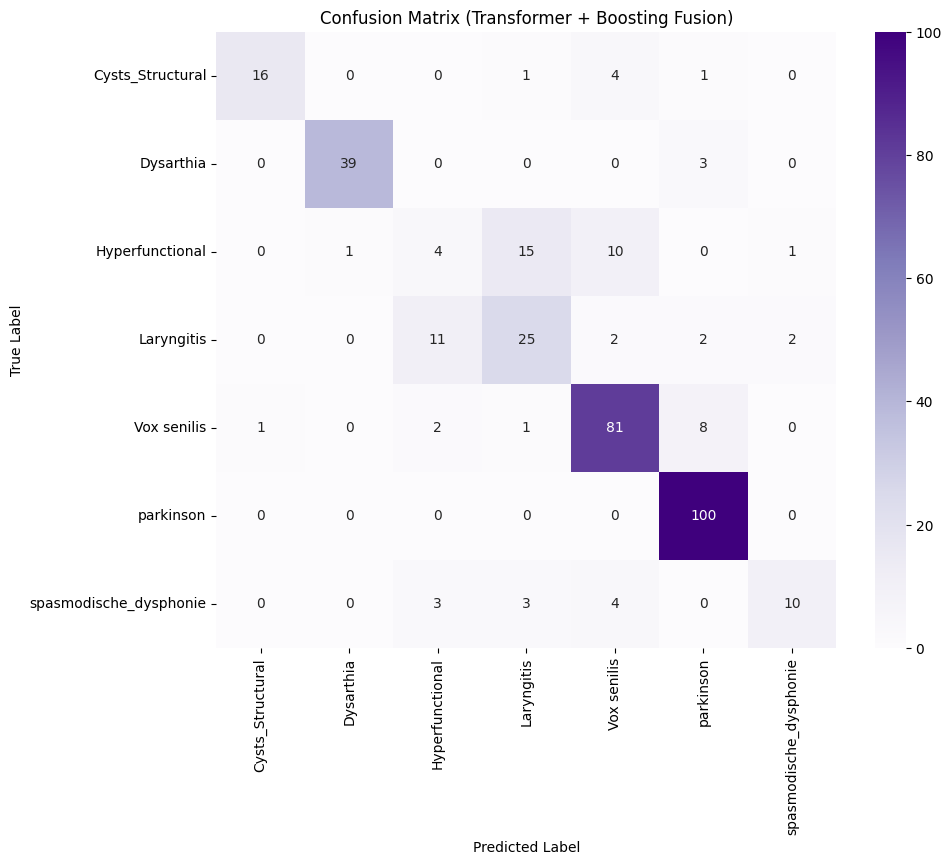

In [22]:
import torch
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ================= CONFIG =================
FEATURE_DIR = Path("features")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ==========================================

def load_tabular_features(split="train"):
    """Helper to load flat statistics for Boosting"""
    mel_dir = FEATURE_DIR / "mel" / split
    sfm_dir = FEATURE_DIR / "sfm" / split
    classes = sorted([d.name for d in mel_dir.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}
    X, y = [], []
    
    print(f"📊 Loading '{split}' stats...")
    for cls in classes:
        files = list((mel_dir / cls).glob("*.npy"))
        for f in files:
            sfm_path = sfm_dir / cls / f.name
            if not sfm_path.exists(): continue
            try:
                mel = np.load(f)
                sfm = np.load(sfm_path)
                if mel.shape[0] != sfm.shape[0]:
                    sfm = scipy.signal.resample(sfm, mel.shape[0], axis=0)
                
                combined = np.hstack([mel, sfm])
                stats = np.hstack([
                    np.mean(combined, axis=0), np.std(combined, axis=0),
                    np.max(combined, axis=0), np.min(combined, axis=0)
                ])
                X.append(stats)
                y.append(class_to_idx[cls])
            except: pass
    return np.array(X), np.array(y), classes

def run_full_ensemble_pipeline():
    # --- STEP 1: RETRAIN BOOSTING MODEL ---
    print("\n🚀 Step 1: Retraining Boosting Model...")
    X_train, y_train, classes = load_tabular_features("train")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    clf = HistGradientBoostingClassifier(
        learning_rate=0.1, max_iter=300, max_depth=15, 
        class_weight='balanced', random_state=42
    )
    clf.fit(X_train_scaled, y_train)
    print("✅ Boosting Model Ready.")

    # --- STEP 2: LOAD TRANSFORMER ---
    print("\n🚀 Step 2: Loading Transformer...")
    model_t = MelSFM_EVA02(len(classes)).to(DEVICE)
    weights_path = "best_mel_sfm_balanced.pth"
    
    if not Path(weights_path).exists():
        print(f"❌ Error: {weights_path} not found. Run the Balanced Training step first!")
        return

    model_t.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model_t.eval()
    print("✅ Transformer Loaded.")

    # --- STEP 3: FUSION INFERENCE ---
    print("\n🚀 Step 3: Running Fusion on Balanced Test Set...")
    # Load Test Data Manually to ensure alignment
    split = "test"
    mel_dir = FEATURE_DIR / "mel" / split
    sfm_dir = FEATURE_DIR / "sfm" / split
    
    all_preds, all_labels = [], []
    
    for cls in classes:
        files = sorted(list((mel_dir / cls).glob("*.npy")))
        for f in files:
            sfm_path = sfm_dir / cls / f.name
            if not sfm_path.exists(): continue
                
            try:
                # Load Raw
                mel = np.load(f)
                sfm = np.load(sfm_path)
                
                # Fix Length
                if mel.shape[0] != sfm.shape[0]:
                    sfm_resized = scipy.signal.resample(sfm, mel.shape[0], axis=0)
                else:
                    sfm_resized = sfm
                    
                # A. TRANSFORMER PREDICTION
                t_mel = torch.from_numpy(mel).float().unsqueeze(0).to(DEVICE)
                t_sfm = torch.from_numpy(sfm_resized).float().unsqueeze(0).to(DEVICE)
                t_mask = torch.ones((1, t_sfm.shape[1]), dtype=torch.bool).to(DEVICE)
                
                with torch.no_grad():
                    logits_t, _ = model_t(t_mel, t_sfm, t_mask)
                    probs_t = torch.softmax(logits_t, dim=1).cpu().numpy()[0]
                
                # B. BOOSTING PREDICTION
                combined = np.hstack([mel, sfm_resized])
                stats = np.hstack([
                    np.mean(combined, axis=0), np.std(combined, axis=0),
                    np.max(combined, axis=0), np.min(combined, axis=0)
                ]).reshape(1, -1)
                stats_scaled = scaler.transform(stats)
                
                probs_b = clf.predict_proba(stats_scaled)[0]
                
                # C. FUSION (Weighted Average)
                # Boosting is usually stronger, so we give it slightly higher weight
                final_prob = (0.3 * probs_t) + (0.7 * probs_b)
                pred_label = final_prob.argmax()
                
                all_preds.append(pred_label)
                all_labels.append(classes.index(cls))
                
            except Exception as e:
                pass

    # --- RESULTS ---
    print("\n" + "="*60)
    print("📊 HYBRID ENSEMBLE RESULTS")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Transformer + Boosting Fusion)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Execute
run_full_ensemble_pipeline()

🔄 Re-training Boosting Model for Feature Importance...
✅ Boosting Model Ready.

📊 Generating Figure 1: Global Feature Importance...


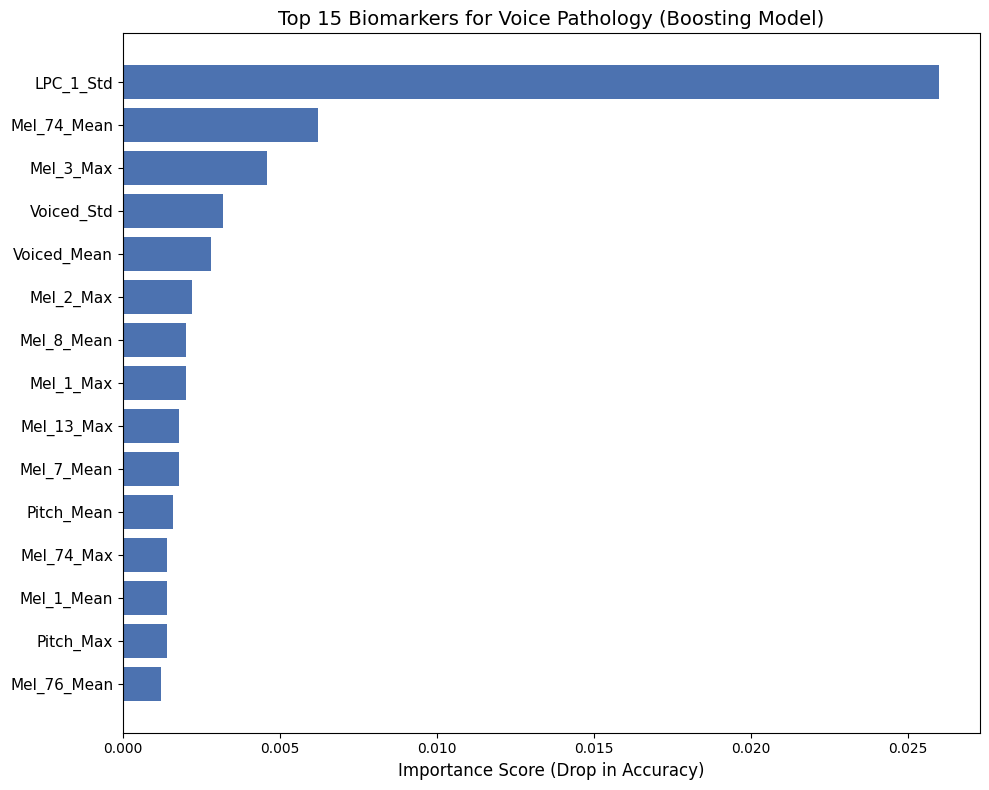


🔍 Generating Figure 2: Local Attention Map...
test: 350 samples


IndexError: Inconsistent shape between the condition and the input (got (149, 1) and (149,))

<Figure size 1000x600 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scipy.signal
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# ================= 1. RE-TRAIN BOOSTING MODEL (To fix NameError) =================
print("🔄 Re-training Boosting Model for Feature Importance...")

# Helper to load data
def load_tabular_features(split="train"):
    mel_dir = FEATURE_DIR / "mel" / split
    sfm_dir = FEATURE_DIR / "sfm" / split
    classes = sorted([d.name for d in mel_dir.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}
    X, y = [], []
    
    # We load a subset (first 2000) to speed up plotting if dataset is huge
    count = 0 
    for cls in classes:
        files = list((mel_dir / cls).glob("*.npy"))
        for f in files:
            try:
                sfm_path = sfm_dir / cls / f.name
                if not sfm_path.exists(): continue
                
                mel = np.load(f)
                sfm = np.load(sfm_path)
                if mel.shape[0] != sfm.shape[0]:
                    sfm = scipy.signal.resample(sfm, mel.shape[0], axis=0)
                
                combined = np.hstack([mel, sfm])
                # Calculate Stats: Mean, Std, Max, Min
                stats = np.hstack([
                    np.mean(combined, axis=0), np.std(combined, axis=0),
                    np.max(combined, axis=0), np.min(combined, axis=0)
                ])
                X.append(stats)
                y.append(class_to_idx[cls])
                count += 1
            except: pass
    return np.array(X), np.array(y), classes

X_train, y_train, classes = load_tabular_features("train")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train quickly
clf = HistGradientBoostingClassifier(max_iter=100, random_state=42)
clf.fit(X_train_scaled, y_train)
print("✅ Boosting Model Ready.")

# ================= 2. GENERATE FIGURE 1: FEATURE IMPORTANCE =================
print("\n📊 Generating Figure 1: Global Feature Importance...")

# Construct Feature Names correctly
# Structure: [Means... Stds... Maxs... Mins...]
base_names = [f"Mel_{i}" for i in range(80)] + ["Pitch", "Energy", "Voiced", "LPC_1", "LPC_2", "LPC_3", "LPC_4"]
feature_names = []
for stat in ["Mean", "Std", "Max", "Min"]:
    for name in base_names:
        feature_names.append(f"{name}_{stat}")

# Calculate Importance (using a subset of 1000 samples for speed)
subset_idx = np.random.choice(len(X_train_scaled), min(1000, len(X_train_scaled)), replace=False)
result = permutation_importance(
    clf, X_train_scaled[subset_idx], y_train[subset_idx], n_repeats=5, random_state=42
)

# Plot Top 15
sorted_idx = result.importances_mean.argsort()[-15:]
plt.figure(figsize=(10, 8))
plt.barh(range(15), result.importances_mean[sorted_idx], align='center', color='#4c72b0')
plt.yticks(range(15), np.array(feature_names)[sorted_idx], fontsize=11)
plt.xlabel("Importance Score (Drop in Accuracy)", fontsize=12)
plt.title("Top 15 Biomarkers for Voice Pathology (Boosting Model)", fontsize=14)
plt.tight_layout()
plt.show()

# ================= 3. GENERATE FIGURE 2: ATTENTION MAP =================
print("\n🔍 Generating Figure 2: Local Attention Map...")

def visualize_attention(model_path, class_name):
    # Load Transformer
    model = MelSFM_EVA02(num_classes=len(classes)).to(CONFIG["device"])
    weights = torch.load(model_path, map_location=CONFIG["device"])
    model.load_state_dict(weights)
    model.eval()
    
    # Find sample
    test_ds = MelSFMDataset("test")
    target_idx = test_ds.class_to_idx[class_name]
    
    found_mel, found_sfm = None, None
    for mel, sfm, label in test_ds:
        if label.item() == target_idx:
            found_mel = mel.unsqueeze(0).to(CONFIG["device"])
            found_sfm = sfm.unsqueeze(0).to(CONFIG["device"])
            break
            
    if found_mel is None:
        print(f"Sample for {class_name} not found.")
        return

    # Forward Pass
    sfm_mask = torch.ones((1, found_sfm.shape[1]), dtype=torch.bool).to(CONFIG["device"])
    with torch.no_grad():
        _, attn_weights = model(found_mel, found_sfm, sfm_mask)
        # Average over heads
        avg_attn = attn_weights.mean(dim=1).squeeze(0).cpu().numpy()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(avg_attn, cmap="viridis", cbar_kws={'label': 'Attention Intensity'})
    plt.title(f"Transformer Attention Map: {class_name}\n(Where the model looks in time)", fontsize=14)
    plt.xlabel("Physical Features (SFM) Time", fontsize=12)
    plt.ylabel("Mel-Spectrogram Time", fontsize=12)
    plt.show()

# Run XAI Visualization
visualize_attention("best_mel_sfm_balanced.pth", "parkinson")

🔍 Generating Attention Map for 'parkinson'...
test: 350 samples


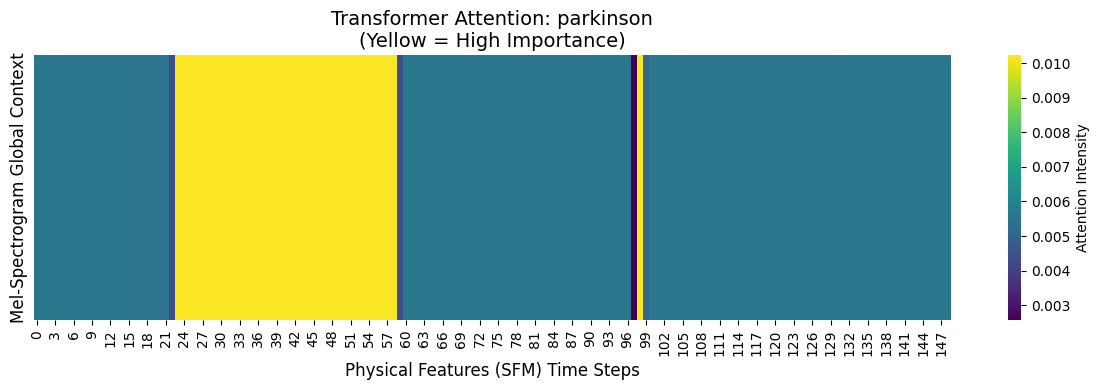

🔍 Generating Attention Map for 'Cysts_Structural'...
test: 350 samples


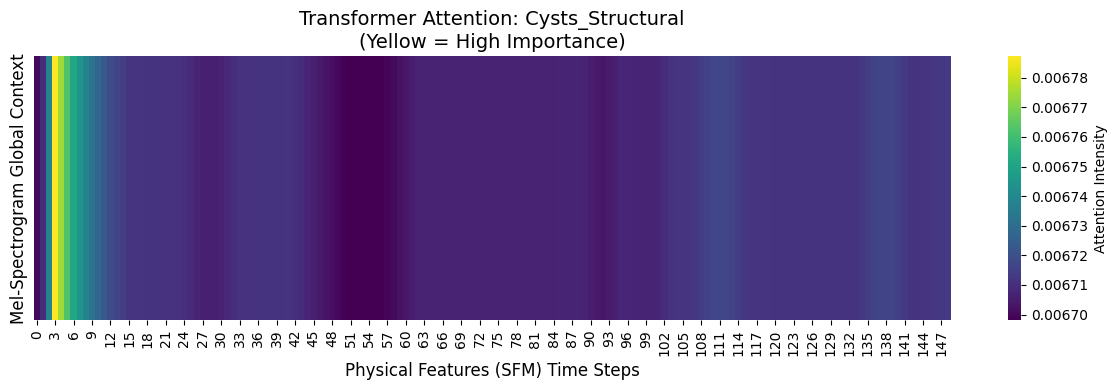

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_attention(model_path, class_name):
    print(f"🔍 Generating Attention Map for '{class_name}'...")
    
    # 1. Load Model & Weights
    model = MelSFM_EVA02(num_classes=len(classes)).to(CONFIG["device"])
    
    try:
        weights = torch.load(model_path, map_location=CONFIG["device"])
        model.load_state_dict(weights)
    except Exception as e:
        print(f"❌ Could not load weights: {e}")
        return
        
    model.eval()
    
    # 2. Find a sample
    test_ds = MelSFMDataset("test")
    target_idx = test_ds.class_to_idx.get(class_name)
    
    if target_idx is None:
        print(f"❌ Class '{class_name}' not found in dataset.")
        return
    
    found_mel, found_sfm = None, None
    for mel, sfm, label in test_ds:
        if label.item() == target_idx:
            found_mel = mel.unsqueeze(0).to(CONFIG["device"]) # (1, T, 80)
            found_sfm = sfm.unsqueeze(0).to(CONFIG["device"]) # (1, T, 7)
            break
            
    if found_mel is None:
        print(f"⚠️ No sample found for class '{class_name}'")
        return

    # 3. Forward Pass
    sfm_mask = torch.ones((1, found_sfm.shape[1]), dtype=torch.bool).to(CONFIG["device"])
    
    with torch.no_grad():
        _, attn_weights = model(found_mel, found_sfm, sfm_mask)
        
        # attn_weights shape: (Batch, NumHeads, TargetSeq, SourceSeq) -> (1, 8, 1, 149)
        # We average over heads (dim 1) and squeeze the batch (dim 0) & target (dim 2)
        avg_attn = attn_weights.mean(dim=1).squeeze().cpu().numpy()
        
        # --- THE FIX: Force it to be 2D (1 Row, N Columns) ---
        # If avg_attn is (149,), this makes it (1, 149)
        avg_attn = avg_attn.reshape(1, -1)

    # 4. Plot
    plt.figure(figsize=(12, 4)) # Wide and short figure
    sns.heatmap(avg_attn, cmap="viridis", cbar_kws={'label': 'Attention Intensity'}, yticklabels=False)
    
    plt.title(f"Transformer Attention: {class_name}\n(Yellow = High Importance)", fontsize=14)
    plt.xlabel("Physical Features (SFM) Time Steps", fontsize=12)
    plt.ylabel("Mel-Spectrogram Global Context", fontsize=12)
    plt.tight_layout()
    plt.show()

# Run it
visualize_attention("best_mel_sfm_balanced.pth", "parkinson")
visualize_attention("best_mel_sfm_balanced.pth", "Cysts_Structural")